In [1]:
import dataframe_image as dfi
import xgboost
import os
import shap

from fpdf import FPDF
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.inspection import PartialDependenceDisplay as PDP
from sklearn.inspection import partial_dependence as pdep
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%load_ext autoreload
%autoreload 2
import market_models.src.features.build_features as build_features

xgboost.set_config(verbosity=0)


2023-12-03 09:52:24.183176: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 09:52:24.213448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 09:52:24.213483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 09:52:24.214670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 09:52:24.220260: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 09:52:24.220776: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def prepareDir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for file in os.listdir(dir):
        os.remove(dir + file)

In [3]:
####### PATHS

INPUT = '../data/processed/'
INTERMEDIATE = '../reports/'
OUTPUT = '..data/processed/'

DATA_NAME = 'netrisk_casco_2023_11_14__2023_11_20'

DATA_PATH = f'{INPUT}{DATA_NAME}_processed.csv'
FEATURES_PATH = f'{INPUT}{DATA_NAME}_features.txt'
CATEGORIES_PATH = f'{INPUT}external/'
KPI_DATA_PATH = f'{INTERMEDIATE}{DATA_NAME}_pdf_data/'
PDF_PATH = OUTPUT + DATA_PATH.split('/')[2].replace('.xlsx', '') + '_'

####### CONSTANTS

TEST_SIZE = 0.1
RANDOM_STATE = 42


def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_labels()
    c = 1
    den = abs(x) + c
    grad = c * x / den
    hess = c * c / den ** 2
    return grad, hess


DEFAULT_PARAMS = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eval_metric': 'mae',
    'n_estimators': 100,
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'num_boost_round': 100,
    'early_stopping_rounds': None,
    'seed': 42
}

BONUS_MALUS_CLASSES = ['B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2', 'B1', 'A0', 'M1', 'M2', 'M3', 'M4']
KPI_TABLE_COLUMNS = ['MAE', 'sd MAE', 'RMSE', 'sd RMSE', 'MAPE', 'sd MAPE', 'Avg target']

TARGET_VARIABLE = 'KÖBE_price'
PRED_TARGET_VARIABLE = f'predicted_{TARGET_VARIABLE}'
CATEGORIES_PATH = f'{CATEGORIES_PATH}{TARGET_VARIABLE}'

prepareDir(KPI_DATA_PATH)

In [4]:
data = pd.read_csv(DATA_PATH)

In [5]:
data = pd.read_csv(DATA_PATH)
with open(FEATURES_PATH) as file:
    features = file.readlines()
    features = [feature.replace('\n', '') for feature in features]
    feature_dtypes = {feature.split(',')[0]: feature.split(',')[1] for feature in features}
    features = [feature.split(',')[0] for feature in features]

for feature in features:
    data[feature] = data[feature].astype(feature_dtypes[feature])
    if data[feature].dtype == 'category' and feature == 'BonusMalus':
        ordinal_encoder = OrdinalEncoder(categories=[BONUS_MALUS_CLASSES])
        data[feature] = ordinal_encoder.fit_transform(data[[feature]])
    elif data[feature].dtype == 'category':
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])

In [6]:
# Make last column name a variable to generelize
data = data[features + [TARGET_VARIABLE]]
data = data.dropna()

In [7]:
features

['isRecent',
 'CarMake',
 'CarAge',
 'ccm',
 'kw',
 'kg',
 'car_value',
 'CarMakerCategory',
 'PostalCode',
 'PostalCode2',
 'PostalCode3',
 'Category',
 'Longitude',
 'Latitude',
 'Age',
 'LicenseAge',
 'BonusMalus',
 'BonusMalusCode']

In [8]:
data.dtypes

isRecent               bool
CarMake               int64
CarAge                int64
ccm                   int64
kw                    int64
kg                    int64
car_value           float64
CarMakerCategory    float64
PostalCode            int64
PostalCode2           int64
PostalCode3           int64
Category              int64
Longitude           float64
Latitude            float64
Age                   int64
LicenseAge            int64
BonusMalus          float64
BonusMalusCode        int64
KÖBE_price          float64
dtype: object

In [9]:
# Make data overview

describe = pd.concat([data.describe(),
                      pd.DataFrame(np.array([len(data[col].unique()) for col in data.columns]).reshape(1, -1),
                                   index=['unique'], columns=data.columns)])
describeStyle = describe.T.style.format(precision=2)
dfi.export(describeStyle, KPI_DATA_PATH + 'dataOverview.png', dpi=200)

In [10]:
# Various model related methods

def pseudo_hubber_loss_objective(preds, dtrain):
    d = preds - dtrain.get_labels()
    h = 1
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess


def modelFit(trData, n_estimators=1200, max_depth=8):
    model = xgboost.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=0.1, gamma=5, subsample=1,
                                 colsample_bytree=0.8, min_child_weight=1, eval_metric='mae', enable_categorical=True)
    model.fit(transposed_train[features], transposed_train[TARGET_VARIABLE])
    return model


def makeDMatrix(features, target):
    return xgboost.DMatrix(features, target, enable_categorical=True)


def modelTrain(trData, teData, param=None):
    dtrain = xgboost.DMatrix(trData[features], trData[TARGET_VARIABLE], enable_categorical=True)
    dtest = xgboost.DMatrix(teData[features], teData[TARGET_VARIABLE], enable_categorical=True)

    if param is None:
        param = DEFAULT_PARAMS

    param['max_depth'] = int(param['max_depth'])
    param['eval_metric'] = 'mae'

    evallist = [(dtrain, 'train'), (dtrain, 'eval')]

    return xgboost.train(param, dtrain, num_boost_round=param['n_estimators'], evals=evallist, verbose_eval=False)


def modelCV(data, param=None):
    dtrain = xgboost.DMatrix(data[features], data[TARGET_VARIABLE], enable_categorical=True)
    if param is None:
        param = DEFAULT_PARAMS
    param['max_depth'] = int(param['max_depth'])
    param['eval_metric'] = 'mae'
    return xgboost.cv(param, dtrain, param['n_estimators'], nfold=3, verbose_eval=False, as_pandas=True)


def mergePredictions(model):
    output = transposed_test.copy()
    try:
        output[PRED_TARGET_VARIABLE] = model.predict(transposed_test[features])
    except Exception as e:
        dtest = xgboost.DMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE], enable_categorical=True)
        output[PRED_TARGET_VARIABLE] = model.predict(dtest)
    output['error'] = output[TARGET_VARIABLE] - output[PRED_TARGET_VARIABLE]
    output['percentageError'] = output['error'] / output[TARGET_VARIABLE] * 100
    return output


def plotHistErrorPercenage(preds):
    plt.hist(preds.percentageError, range=[-100, 100], bins=40,
             weights=np.ones(len(preds.percentageError)) / len(preds.percentageError))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(KPI_DATA_PATH + 'ErrorDistribution.jpg')
    plt.show()


def plotFeatureDistribution(data, feature):
    plt.figure(figsize=(10, 10))
    if feature in feature_dtypes.keys() and feature_dtypes[feature] == 'bool':
        data[feature].value_counts().plot(kind='bar', title=feature)
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches='tight')
    else:
        plt.hist(data[feature], bins=40, weights=np.ones(len(data[feature])) / len(data[feature]), alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Percent of values')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches='tight')
    plt.close()



In [11]:
def kFoldCrossValidation(k=5, param=None, debug=True):
    kf = KFold(n_splits=k)
    maes = []
    mses = []
    mapes = []
    fold_num = 0
    for transposed_train, transposed_test in kf.split(data):
        fold_num += 1
        transposed_train, transposed_test = data.iloc[transposed_train], data.iloc[transposed_test]
        trainModel = modelTrain(transposed_train, transposed_test, param=param)
        dmat = makeDMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE])
        mae = mean_absolute_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        mse = mean_squared_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        mape = mean_absolute_percentage_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        if debug:
            print(f"Summary for fold {fold_num}")
            print("Mean absolute error is {}, which is {}% of mean {}.".format(round(mae, 3), round(
                mae / data[TARGET_VARIABLE].mean() * 100, 3), TARGET_VARIABLE))
            print("Mean square error is {}.".format(round(mse, 3)))
            print("Mean absolute percentage error is {}%.".format(round(mape * 100, 3)))
            print("-------------------------------------------------------------")
        maes.append(mae)
        mses.append(mse)
        mapes.append(mape)

    mMae, sMae = np.mean(maes), np.std(maes)
    mRMse, sRMse = np.mean(np.sqrt(mses)), np.std(np.sqrt(mses))
    mMape, sMape = np.mean(mapes), np.std(mapes)
    meanPrice = data[TARGET_VARIABLE].mean()

    rmMae, rsMae = round(mMae, 2), round(sMae / mMae * 100, 3)
    rmRMse, rsRMse = round(mRMse, 2), round(sRMse / mRMse * 100, 2)
    rmMape, rsMape = round(mMape * 100, 2), round(sMape / mMape, 3)

    if debug:
        print(
            f"Mean MAE over {k} fold Cross-validation is {rmMae} ± {rsMae}%, which is {round(mMae / meanPrice * 100, 3)} ± {round(sMae / meanPrice * 100, 3)}% percent of mean {TARGET_VARIABLE}.")
        print(f"Mean RMSE over {k} fold Cross-validation is {rmRMse} ± {rsRMse}%.")
        print(f"Mean MAPE over {k} fold Cross-validation is {rmMape} ± {rsMape}%.")

    return rmMae, rmRMse, rmMape

In [12]:
hyperparameter_ranges = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(100, 1100, 100),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.arange(0.5, 1.01, 0.1),
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),
    'gamma': np.arange(0, 0.21, 0.01),
    'lambda': np.arange(0, 1.1, 0.1),
}


def hyperparameter_tuning(params, plot_search=False):
    best_hyperparameters = {}  # To store the best hyperparameter value for each parameter
    min_mae_values = {}  # To store the corresponding minimum MAE values

    for hp, hp_values in hyperparameter_ranges.items():
        maes = []
        print(f"Iterating over {hp} values...")

        # Initialize the minimum MAE and corresponding hyperparameter value
        min_mae = float('inf')
        best_value = None
        current_params = params
        for value in hp_values:
            current_params[hp] = value
            mae, mse, mape = kFoldCrossValidation(k=3, param=current_params, debug=False)
            maes.append(mae)

            # Check if the current value gives a lower MAE
            if mae < min_mae:
                min_mae = mae
                best_value = value

        # Store the best hyperparameter value in the dictionary
        best_hyperparameters[hp] = best_value
        min_mae_values[hp] = min_mae

        if plot_search:
            # Plot the results
            plt.title(f'Search for optimal {hp} value:')
            plt.plot(hp_values, maes)
            plt.xlabel(f'{hp}')
            plt.ylabel('Mean Absolute Error (MAE)')
            plt.show()

    # Display the best hyperparameter values
    print("\nBest Hyperparameter Values:")
    for hp, value in best_hyperparameters.items():
        print(f"{hp}: {value}")

    mae, mse, mape = kFoldCrossValidation(k=3, param=best_hyperparameters)

    return best_hyperparameters, mae

In [13]:
transposed_train, transposed_test = train_test_split(data, test_size=0.1, random_state=42)

In [14]:
kFoldCrossValidation(3, DEFAULT_PARAMS, debug=True)

Summary for fold 1
Mean absolute error is 3254.455, which is 3.482% of mean KÖBE_price.
Mean square error is 69519616.452.
Mean absolute percentage error is 2.739%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 3110.96, which is 3.329% of mean KÖBE_price.
Mean square error is 44202856.414.
Mean absolute percentage error is 3.212%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 3403.693, which is 3.642% of mean KÖBE_price.
Mean square error is 58268173.4.
Mean absolute percentage error is 3.562%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 3256.37 ± 3.67%, which is 3.484 ± 0.128% percent of mean KÖBE_price.
Mean RMSE over 3 fold Cross-validation is 7539.91 ± 9.19%.
Mean MAPE over 3 fold Cross-validation is 3.17 ± 0.106%.


(3256.37, 7539.91, 3.17)

In [110]:
maes = []
params = DEFAULT_PARAMS
best_hyperparameters, mae = hyperparameter_tuning(params, plot_search=True)

Iterating over learning_rate values...


KeyboardInterrupt: 

In [15]:
transposed_train, transposed_test = train_test_split(data, test_size=0.2, random_state=42)
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1300, 100, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 0.2),
    'lambda': hp.uniform('lambda', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 40, 180),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'seed': 0,
}


def objective(space):
    params = space.copy()
    mae, rmse, mape = kFoldCrossValidation(3, params, debug=False)
    print(f"Score: {mae}")
    return {"loss": mae, 'status': STATUS_OK}


trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials,
                        return_argmin=False)

  0%|          | 0/100 [00:16<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [16]:
best_hyperparams

KeyError: 112

In [113]:
modelCV(data, best_hyperparams)['test-mae-mean'].idxmin()

1087

In [114]:
kFoldCrossValidation(k=3, param=best_hyperparams, debug=True)

Summary for fold 1
Mean absolute error is 2892.478, which is 3.095% of mean KÖBE_price.
Mean square error is 53451843.443.
Mean absolute percentage error is 2.451%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 2694.29, which is 2.883% of mean KÖBE_price.
Mean square error is 28473098.287.
Mean absolute percentage error is 2.836%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 3115.894, which is 3.334% of mean KÖBE_price.
Mean square error is 42660873.043.
Mean absolute percentage error is 3.393%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 2900.89 ± 5.937%, which is 3.104 ± 0.184% percent of mean KÖBE_price.
Mean RMSE over 3 fold Cross-validation is 6392.87 ± 12.71%.
Mean MAPE over 3 fold Cross-validation is 2.89 ± 0.134%.


(2900.89, 6392.87, 2.89)

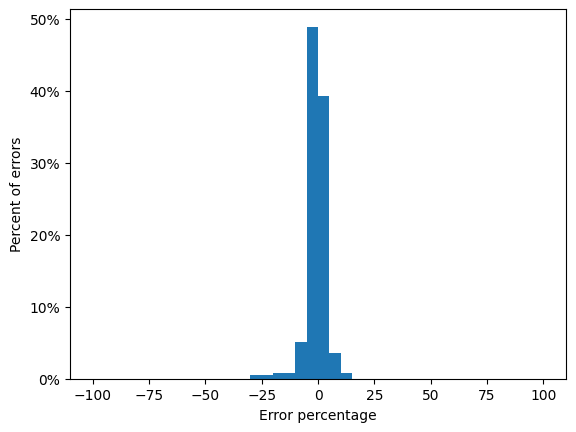

In [17]:
model = modelTrain(transposed_train, transposed_test)
out = mergePredictions(model)
plotHistErrorPercenage(out)

In [18]:
out.percentageError.abs().quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])

0.10     0.104309
0.20     0.185365
0.30     0.322389
0.40     0.500352
0.50     0.810008
0.60     1.298178
0.70     1.961673
0.80     3.370317
0.90     5.826520
0.99    17.183704
Name: percentageError, dtype: float64

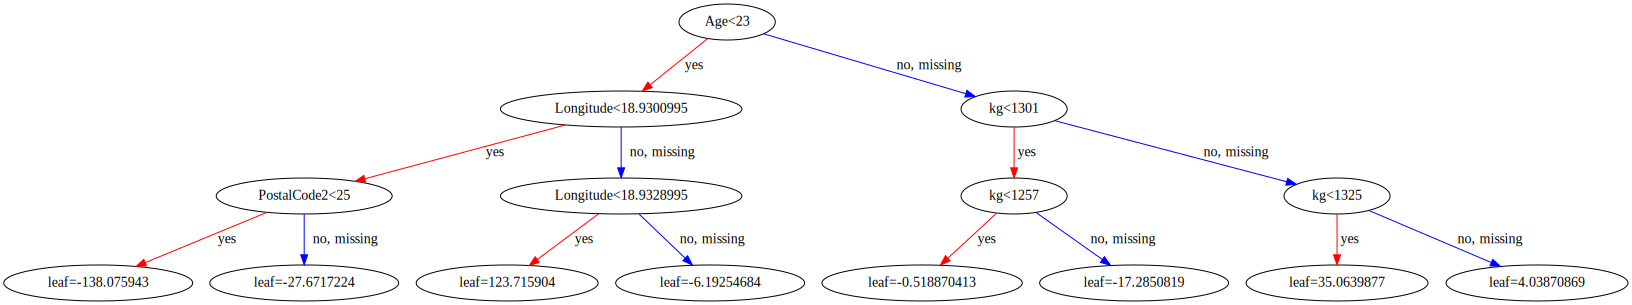

In [120]:
xgboost.to_graphviz(model, num_trees = 1087)

In [16]:
kpi_data = [[rmMae, rsMae, rmRMse, rsRMse, rmMape, rsMape, round(data[TARGET_VARIABLE].mean(), 1)]]
kpi = pd.DataFrame(data=kpi_data, columns=KPI_TABLE_COLUMNS).astype('str')

In [125]:
for col in data.columns:
    plotFeatureDistribution(data, col)

In [127]:
model

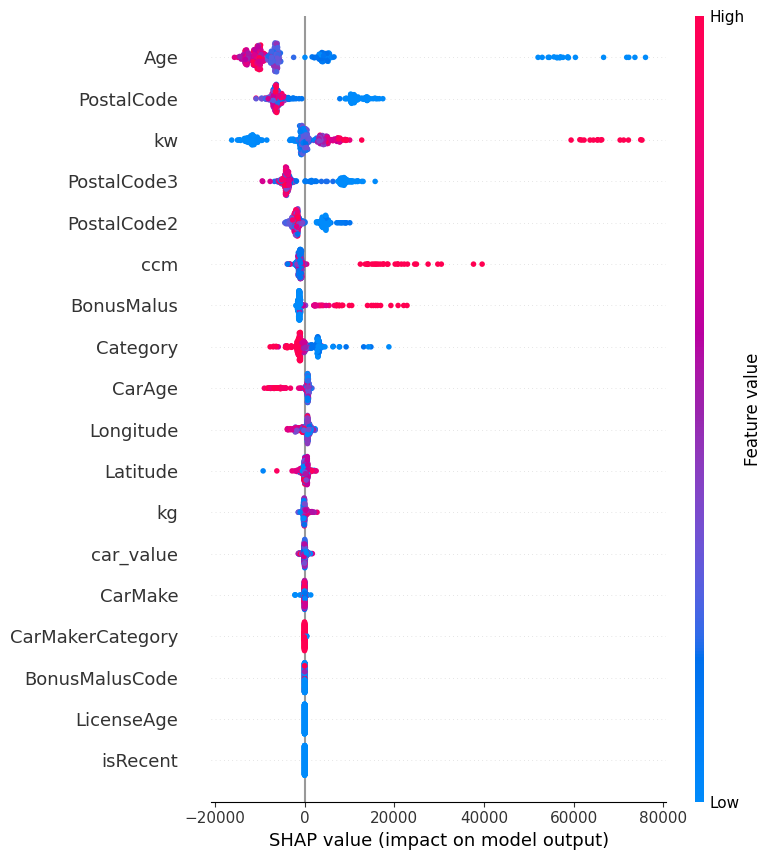

In [54]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(transposed_test[features].values)

shap.summary_plot(shap_values, transposed_test[features], feature_names=features)

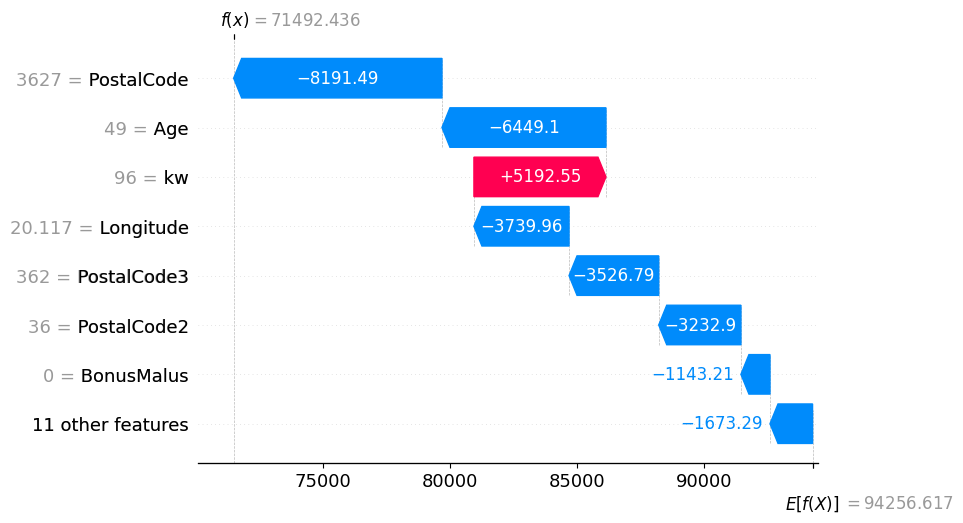

In [55]:
id = 21
plt.figure(figsize=(20, 20))
shap.waterfall_plot(shap.Explanation(values=shap_values[id],
                                     base_values=explainer.expected_value,
                                     data=transposed_test.iloc[id],
                                     feature_names=features),
                    max_display=8)  # Adjust max_display as needed

plt.show()

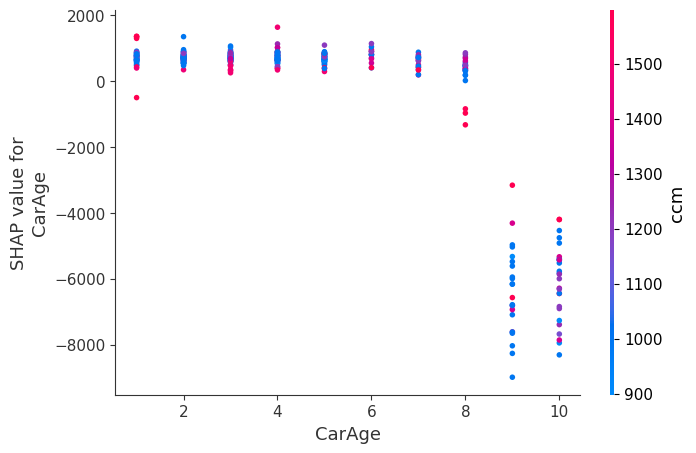

In [63]:
shap.dependence_plot('CarAge', shap_values, transposed_test[features])

In [95]:
def pdpSingle(feature):
    return PDP.from_estimator(scModel, transposed_train[features].select_dtypes(include='number'), [feature],
                              kind='both', ice_lines_kw={"color": "black"}, centered=True,
                              pd_line_kw={"color": "red", "lw": 3, "linestyle": "--"})


for col in transposed_train[features].select_dtypes(include='number').columns:
    pdpSingle(col).figure_.savefig(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg')
    plt.close()

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


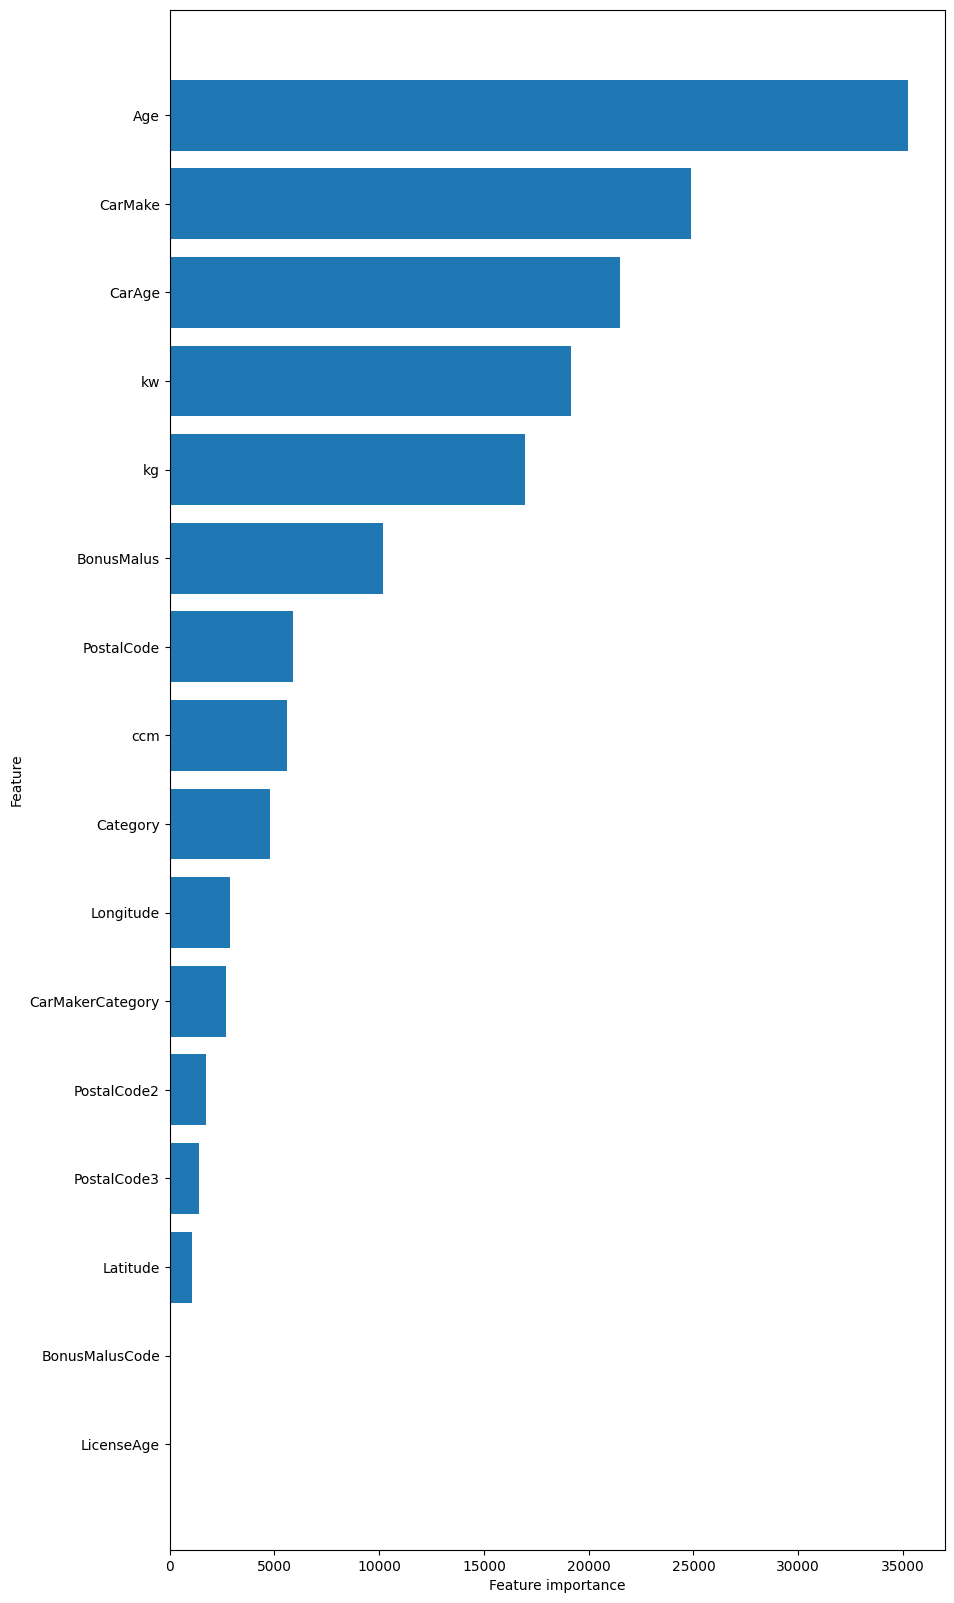

In [112]:
partialDepenadanceFeatureImportance = []
for col in transposed_train[features].select_dtypes(include='number').columns:
    partialDepenadanceFeatureImportance.append(
        np.std(pdep(scModel, transposed_train[features].select_dtypes(include='number'), [col])['average']))

cols = transposed_train[features].select_dtypes(include='number').columns
ind = [x for _, x in sorted(zip(partialDepenadanceFeatureImportance, cols))]
plt.figure(figsize=(10, 20))
plt.barh(y=ind, width=sorted(partialDepenadanceFeatureImportance))
plt.ylabel('Feature')
plt.xlabel('Feature importance')
plt.savefig(KPI_DATA_PATH + 'PDPimportancePlot.jpg', bbox_inches='tight')

In [50]:
def getQauntSplit(step=50):
    return [i / 1000 for i in range(0, 1001, step)]


quant = getQauntSplit(int(np.ceil(100000 / len(transposed_train))))
qr = transposed_test[TARGET_VARIABLE].quantile(quant)
qp = pd.Series(model.predict(makeDMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE]))).quantile(quant)

plt.scatter(qr, qp, alpha=0.8, s=40)
x = np.linspace(qr.min(), qr.max())
plt.plot(x, x, c='r')
plt.xlabel('Real quantiles for training data')
plt.ylabel('Predicted quantiles for training data')
plt.savefig(KPI_DATA_PATH + 'QQplot.jpg', bbox_inches='tight')
plt.close()

In [52]:
def quantPlot(out, feature, numQuant=20):
    type = True  # Does the feature have more than 20 unique values in train data, 20 because it looks bad with more
    fQuant = None
    cats = None
    if len(out[feature].unique()) > 30 and feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object':
        return
    if len(out[feature].unique()) < numQuant or (
            feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object'):
        out['QuantCat'] = out[feature]
        type = False
    else:
        fQuant = out[feature].quantile(getQauntSplit(1000 // numQuant)).values
        cats = list(pd.Series(fQuant).unique())

        def getQId(x):
            for i in range(0, len(cats) - 1):
                if x >= cats[i] and x <= cats[i + 1]:
                    return i
            return len(cats) - 1

        out['QuantCat'] = out[feature].apply(lambda x: getQId(x))
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]

    agg_age = out.groupby('QuantCat')

    fig, ax = plt.subplots(figsize=(14, 14))
    if type:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        ax.set_xticks(sorted(list(out['QuantCat'].unique())))
    else:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        if feature == 'CarMaker':
            ax.set_xticklabels(sorted([str(x)[:4] for x in list(out['QuantCat'].unique())]))
        else:
            ax.set_xticklabels(sorted(list(out['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real', 'Predicted'])
    plt.savefig(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', bbox_inches='tight')
    plt.close()
    ret = pd.DataFrame(agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean())
    #print(ret)
    if type:
        #print(cats, out['QuantCat'].unique())
        ret.index = [cats[i] for i in range(len(cats)) if i in out['QuantCat'].unique()]

    return ret


out = mergePredictions(model)
agg_errors = {}
for col in transposed_test.columns:
    agg_errors[col] = quantPlot(out, col)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


In [53]:
# Function to compare two models based on quantile mean aggregated by a feature

def quantPlots(outs, feature, numQuant=20):
    type = True
    fQuant = None
    featureCol = outs[0][feature]
    if len(featureCol.unique()) < numQuant:
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = featureCol
        type = False
    else:
        fQuant = featureCol.quantile(getQauntSplit(1000 // numQuant)).values
        print(fQuant)

        def getQId(x):
            id = 0
            while id < len(fQuant) - 1 and x > fQuant[id]:
                id += 1
                if x <= fQuant[id]:
                    break
            return max(0, id - 1)

        quantCat = featureCol.apply(lambda x: getQId(x))
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = quantCat

    agg_ages = [outs[i].groupby('QuantCat') for i in range(0, len(outs))]
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_ages[0][TARGET_VARIABLE].mean(), marker='o', color='b',
            alpha=0.6)
    for agg_age in agg_ages:
        ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean(), marker='o', color='r',
                alpha=0.6)
    if type:
        ax.set_xticks(range(0, numQuant + 1))
    else:
        ax.set_xticks(sorted(list(outs[0]['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real'] + ['Predicted' + str(i) for i in range(1, len(outs) + 1)])
    plt.savefig(KPI_DATA_PATH + 'quantPlots' + col + '.jpg', bbox_inches='tight')
    plt.show()
    ret = pd.DataFrame(
        np.array([agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean() for agg_age in agg_ages])).T
    ret.columns = ['Model' + str(i) + ' error' for i in range(1, len(outs) + 1)]
    print(ret.index)
    if type:
        cats = list(pd.Series(fQuant).unique())
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]
        for i in range(len(cats)):
            print(feature, cats[i], agg_age[TARGET_VARIABLE].mean().iloc[i])
        ret.index = cats

    return ret

In [54]:
# Inherits FPDF class

class PDF(FPDF):
    def __init__(self):
        super().__init__()

    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8, 'Model', 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')


# Create the KPI report PDF

def makePDF():
    ch = 8
    QUANT_W = 120
    QUANT_H = 120

    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', '', 12)

    for j in range(len(kpi.columns)):
        pdf.cell(w=25, h=ch, txt=kpi.columns[j], border=1, ln=j == (len(kpi.columns) - 1), align='C')
    for j in range(len(kpi.columns)):
        pdf.cell(w=25, h=ch, txt=kpi[kpi.columns[j]].iloc[0] + ('%' if j % 2 else ''), border=1, ln=0, align='C')

    pdf.set_font('Arial', '', 12)
    pdf.cell(w=40, h=3 * ch, txt=' ', border=0, ln=1, align='C')
    pdf.cell(w=40, h=ch, txt='Parameter', border=1, ln=0, align='C')
    pdf.cell(w=40, h=ch, txt='Value', border=1, ln=0, align='C')
    pdf.cell(w=75, h=ch, txt='GridSpace', border=1, ln=1, align='C')
    #    for col, val in params.items():
    #        pdf.cell(w = 40, h = ch, txt = col, border = 1, ln = 0, align = 'C')
    #        pdf.cell(w = 40, h = ch, txt = str(val), border = 1, ln = 0, align = 'C')
    #        pdf.cell(w = 75, h = ch, txt = str(paramsGrid[col]), border = 1,  ln = 1, align = 'C')

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'dataOverview.png', w=200, h=120, type='PNG')

    pdf.add_page()

    idx = 1
    for col in features:
        pdf.image(KPI_DATA_PATH + col + 'Distribution.jpg', x=10, y=5 + (idx - 1) * 90, w=150, h=90, type='JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'PDPimportancePlot.jpg', w=160, h=200, type='JPG')
    pdf.image(KPI_DATA_PATH + 'QQplot.jpg', w=150, h=150, x=100, type='JPG')
    #pdf.image('quantPlotminPrice.jpg', w = 150, h = 150, x = 100, type = 'JPG')

    pdf.add_page()
    idx = 1
    for col in transposed_train[features].select_dtypes(include='number').columns:
        pdf.image(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg', x=10, y=5 + (idx - 1) * 90, w=150, h=90, type='JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    idx = 1
    for col in [transposed_test.columns[-1]] + list(transposed_test.columns[: -1]):
        try:
            pdf.image(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', x=10, y=5 + (idx - 1) * (QUANT_H + 20), w=QUANT_W,
                      h=QUANT_H, type='JPG')
        except Exception as e:
            continue
        # pdf.image(col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 120), w = QUANT_W  / 2, h = QUANT_H / 2, type = 'JPG')
        pdf.set_xy(x=QUANT_W + 20, y=10 + (idx - 1) * (QUANT_H + 20))
        pdf.set_font('Arial', '', 8)
        pdf.cell(w=29, h=ch, txt=col + ' agg', border=1, ln=0, align='C')
        pdf.cell(w=29, h=ch, txt='Mean error', border=1, ln=1, align='C')
        #print(agg_errors[col].iloc[0])
        mx = agg_errors[col].iloc[:, 0].max()
        mn = agg_errors[col].iloc[:, 0].min()

        for i in range(0, len(agg_errors[col])):
            pdf.set_x(QUANT_W + 20)
            cat = agg_errors[col].iloc[i].name
            val = agg_errors[col].iloc[i].values[0]
            print(cat, val)
            if val == mn:
                pdf.set_fill_color(r=255, g=0, b=0)
            elif val == mx:
                pdf.set_fill_color(r=0, g=0, b=255)
            else:
                pdf.set_fill_color(r=255, g=255, b=255)

            pdf.cell(w=29, h=ch / 2, txt=str(cat), border=1, fill=1, ln=0, align='C')
            pdf.cell(w=29, h=ch / 2, txt=str(round(val, 0)), fill=1, border=1, ln=1, align='C')

        idx += 1
        if idx == 3:
            idx = 1
            pdf.add_page()

    return pdf


In [64]:
makePDF().output(PDF_PATH + TARGET_VARIABLE + '_summary.pdf')

53640.0-59760.0 -252.7603218129152
59760.0-62400.0 -393.88671875
62400.0-65160.0 -560.7262561274474
65160.0-67560.0 -632.859375
67560.0-70680.0 -1904.392510775855
70680.0-74760.0 -1476.621329697984
74760.0-79164.0 -1954.239653716213
79164.0-84840.0 -2203.65625
84840.0-91320.0 -1450.4332005033502
91320.0-97440.0 -1731.1023385761655
97440.0-104520.0 -1758.4931187913899
104520.0-110400.0 -1172.088506711414
110400.0-118800.0 -1474.6838613013679
118800.0-127200.0 -1488.7037975993444
127200.0-134760.0 -108.24737835570704
134760.0-145800.0 300.8753188775445
145800.0-155400.0 1012.5033557046845
155400.0-175200.0 3098.259374999994
175200.0-206892.0 745.9913903061242
206892.0-894000.0 11453.246875000012
2023_02_14 -899.2578125
2023_02_21 -37.7014484978572
2023_02_24 879.2180059523671
2023_03_01 -720.4016544117767
2023_06_01 2022.7376644736796
False -207.17491610738216
True 2022.7376644736796
ALFA ROMEO 6582.778952205874
AUDI 6161.3627717391355
BMW -961.5180288461561
CHEVROLET -3797.078125
CITROE

''